In [2]:
import os
from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
from tqdm import tqdm

In [3]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [5]:
# Load dataset using ImageFolder
data_dir = "augmented copy"
train_set = datasets.ImageFolder(os.path.join(data_dir), transform=transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

# Print class names to verify labels
print(f"Classes: {train_set.classes}")

Classes: ['fake', 'real']


In [6]:
def plot_samples(dataset, size_even=6, classes=None):
    
    size_even = 6  # Default number of samples to plot
    dataset = train_set  # Default dataset to use (assuming 'train_set')
    fig, axs = plt.subplots(2, int(size_even // 2))  # Create subplots for the samples

    if classes is None:
        classes = tuple([n for n in range(len(dataset))])  # Default class labels

    n_samples = len(dataset)  # Total number of samples in the dataset

    # Randomly select samples
    samples = np.random.randint(0, high=n_samples - 1, size=int(size_even))

    row = 0
    col = 0
    for n, sample in enumerate(samples):
        img = dataset[sample][0]  # Get the image from the dataset
        label = "y={}".format(classes[int(dataset[sample][1])])  # Get the label for the image

        col = n

        # Determine the row and column index for the current sample
        if n > size_even / 2 - 1:
            row = 1
            col = n - int(size_even / 2)

        # Display the image and label in the corresponding subplot
        axs[row, col].imshow(make_grid(img, normalize=True).permute(1, 2, 0))
        axs[row, col].set_title(label)
        axs[row, col].axis('off')

In [7]:
def plot_image_patchs(patchs, seq=False):

    if patchs.shape[-3] == 1:
        patchs = patchs.repeat(1, 1, 3, 1, 1)  # Add 3 channel dimension if image is grayscale

    N_patchs = patchs.shape[1]  # Number of image patches

    plot_patchs = make_grid(patchs, normalize=True).permute(0, 2, 3, 1)  # Arrange patches for plotting

    N_rows = int(np.sqrt(N_patchs))  # Number of rows for the grid plot

    # Create subplots for the image patches
    if seq:
        fig, ax = plt.subplots(1, N_rows * N_rows, sharex='col', sharey='row', figsize=(25, 5))
        fig.suptitle("Image as Sequence")
    else:
        fig, ax = plt.subplots(N_rows, N_rows, sharex='col', sharey='row')
        fig.suptitle("Image")

    i, j = 0, 0
    for n in range(N_patchs):
        if seq:
            ax[n].imshow(plot_patchs[n])
            ax[n].set_xlabel(str(n + 1))
            ax[n].axes.xaxis.set_ticklabels([])
            ax[n].axes.yaxis.set_ticklabels([])
        else:
            if n % N_rows == 0 and n != 0:
                i += 1
                j = 0

            ax[i, j].imshow(plot_patchs[n])
            ax[i, j].set_ylabel(str(n + 1))
            ax[i, j].axes.xaxis.set_ticklabels([])
            ax[i, j].axes.yaxis.set_ticklabels([])
            j += 1

    plt.show()


In [8]:
def plot_patchs_lables(X, y, label=True, p_show=0.5):
    # Detach X from its computational graph if it's not a leaf node
    if not (X.is_leaf):
        X = X.detach()

    # Get the shape of the input tensor X
    if X.shape[0] == 49:
        sample = X.shape[1]
        patch = X.shape[0]  # Patch size or sequence length
        dim = X.shape[2]
    if X.shape[0] == 1000:
        sample = X.shape[0]
        patch = X.shape[1]
        dim = X.shape[2]

    # Reshape X and convert it to a numpy array
    X = X.reshape(sample * patch, dim).numpy()

    # Flatten the y tensor and convert it to a numpy array to label each sequence
    colors = y.repeat(patch, 1).T.flatten().numpy()

    # Perform t-SNE on the X data
    X_ = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

    # Create a scatter plot of the t-SNE transformed X data with each class labeled via color
    fig, ax = plt.subplots()
    for color in np.unique(colors):
        temp = colors == color
        ax.scatter(X_[temp, 0], X_[temp, 1], label=color)

    # If the label argument is set to True, add labels to the scatter plot
    if label:
        for i, x in enumerate(X_):
            # Label plots with a probability of p_show
            if np.random.binomial(1, p_show, 1).item() == 1:
                ax.annotate(str(i % patch), (x[0], x[1]))

    # Add a legend to the scatter plot
    ax.legend()

In [9]:
def img_to_patch(x, patch_size, flatten_channels=True):

    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

In [10]:
it=iter(train_loader)
image=next(it)[0]

In [11]:
B, C, H, W = image.shape
print("batch size: {}, number of channels: {}, height: {},  width: {}".format( B, C, H, W ))

batch size: 32, number of channels: 3, height: 128,  width: 128


In [11]:
image[0][0].shape

torch.Size([128, 128])

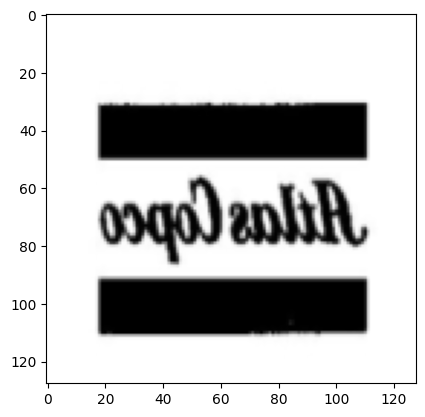

In [12]:
import matplotlib.pyplot as plt
plt.imshow(image[0][0].numpy(),cmap="gray")
plt.show()

In [12]:
patch_size=8

n_patches=(H/patch_size)* (W/patch_size)
n_patches

256.0

In [13]:
patches=img_to_patch(torch.unsqueeze(train_set[2][0],0), patch_size, flatten_channels=False)

In [15]:
patches.shape

torch.Size([1, 256, 3, 8, 8])

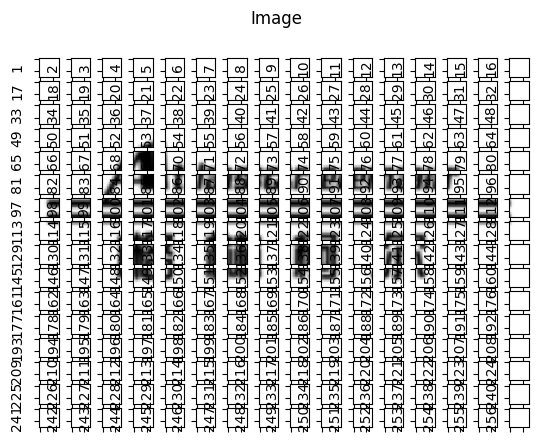

In [16]:
from torchvision.utils import make_grid
plot_image_patchs(patches)


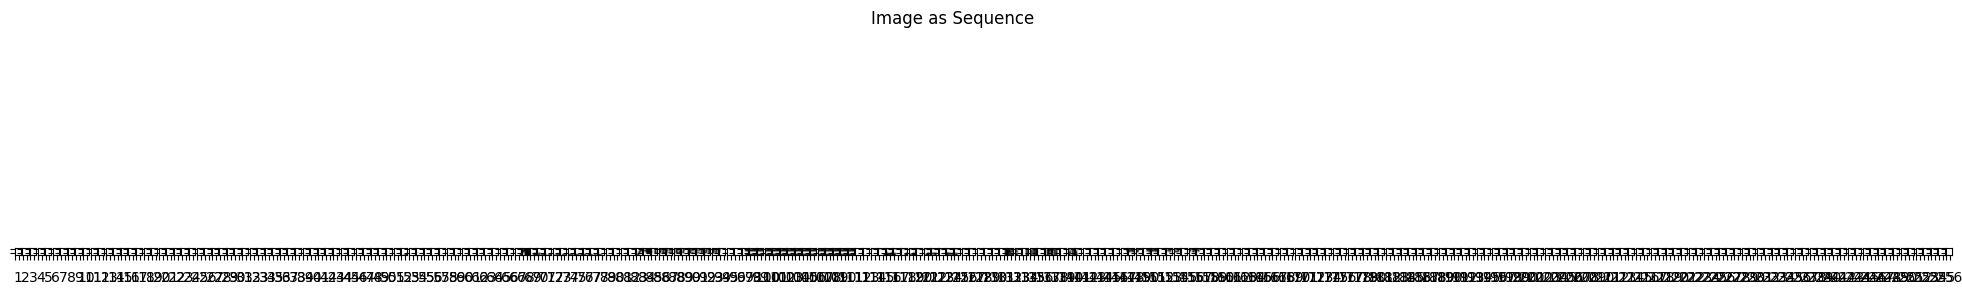

In [17]:
plot_image_patchs(patches, seq=True)

In [14]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
            #source:https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [15]:
class VisionTransformer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, image_size, dropout=0.0):
        super().__init__()

        # Calculate the number of patches
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size ** 2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + self.num_patches, embed_dim))  # 1 for CLS token

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)

        # Ensure positional embeddings match number of patches
        x = x + self.pos_embedding[:, :T + 1]

        # Apply Transformer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out


In [16]:
embed_dim = 256
hidden_dim = 512
num_heads = 8
num_layers = 6
patch_size = 4
num_channels = 3  # Since logos are usually in RGB format (3 channels)
num_patches = 64  # Adjust based on your image size and patch_size
num_classes = 2  # Real or Fake
dropout = 0.2

In [17]:
image_size = 128
patch_size = 16  # Example patch size
model = VisionTransformer(
    embed_dim=embed_dim, hidden_dim=hidden_dim, num_channels=num_channels,
    num_heads=num_heads, num_layers=num_layers, num_classes=2,  # Set to 2 for 'real' and 'fake'
    patch_size=patch_size, image_size=image_size, dropout=dropout
)


# Move model to MPS device (for Mac M1)
model.to(device)

VisionTransformer(
  (input_layer): Linear(in_features=768, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=512, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Laye

In [18]:
lr = 3e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [23]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")
    scheduler.step()

100%|███████████████████████████████████████████| 12/12 [00:04<00:00,  2.51it/s]


Epoch [1/10], Loss: 0.6143093754847845


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.58it/s]


Epoch [2/10], Loss: 0.469661978383859


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.76it/s]


Epoch [3/10], Loss: 0.4774110366900762


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.42it/s]


Epoch [4/10], Loss: 0.4472031742334366


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.71it/s]


Epoch [5/10], Loss: 0.42006675402323407


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.75it/s]


Epoch [6/10], Loss: 0.41780081888039905


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.69it/s]


Epoch [7/10], Loss: 0.4194718872507413


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.76it/s]


Epoch [8/10], Loss: 0.4084031457702319


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.72it/s]


Epoch [9/10], Loss: 0.3751253808538119


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.47it/s]

Epoch [10/10], Loss: 0.3747366617123286


In [24]:
torch.save(model.state_dict(), "logo_classifier.pth")

In [25]:
model.load_state_dict(torch.load("logo_classifier.pth"))

<All keys matched successfully>

In [28]:
from PIL import Image
import torch
from torchvision import transforms

# Define the image transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize the image to match model's expected input size
    transforms.ToTensor(),                        # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))          # Normalize (ensure it matches training normalization)
])

# Function to make a prediction on a single image
def predict_image(model, image_path, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Ensure image is RGB
    image = transform(image).unsqueeze(0)          # Apply transformations and add batch dimension

    # Move image to device (GPU or CPU)
    image = image.to(device)

    # Set the model to evaluation mode and disable gradient calculation
    model.eval()
    with torch.no_grad():
        output = model(image)  # Forward pass through the model
        _, predicted = torch.max(output, 1)  # Get the predicted class (0 or 1)

    return predicted.item()

# Example usage
image_path = "Data/Fake/cepce.png"  # Replace with the path to your logo image
model = VisionTransformer(  # Make sure model parameters match your trained model
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_channels=num_channels,
    num_heads=num_heads,
    num_layers=num_layers,
    num_classes=num_classes,  # Should be 2 for 'real' and 'fake'
    patch_size=patch_size,
    image_size=image_size,
    dropout=dropout
)

# Load trained weights (optional, if you're using the pre-trained model)
model.load_state_dict(torch.load("vit_logo_classifier.pth"))

# Move model to the device (MPS or CPU)
model.to(device)

# Make a prediction
predicted_class = predict_image(model, image_path, device)

# Map predicted class to label
class_names = ['real', 'fake']  # Assuming 0 = 'real' and 1 = 'fake'
print(f"Predicted class: {class_names[predicted_class]}")


Predicted class: real


In [19]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the image transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Ensure image size matches the training input size
    transforms.ToTensor(),                        # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))          # Normalize (ensure this matches your training normalization)
])

# Load the trademarks dataset using ImageFolder
data_dir = "sample/test"  # The directory containing 'real' and 'fake' subfolders
test_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to calculate accuracy
def calculate_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    # Disable gradient computation during inference
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass through the model
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Count the number of correct predictions
    
    # Calculate accuracy
    accuracy = 100 * correct / total
    return accuracy

# Load your trained model (make sure parameters match the trained model)
model = VisionTransformer(
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_channels=num_channels,
    num_heads=num_heads,
    num_layers=num_layers,
    num_classes=num_classes,  # Should be 2 for 'real' and 'fake'
    patch_size=patch_size,
    image_size=image_size,
    dropout=dropout
)

# Load the trained weights
model.load_state_dict(torch.load("logo_classifier.pth"))

# Move the model to the device (CPU or GPU)
model.to(device)

# Calculate the accuracy on the test dataset
accuracy = calculate_accuracy(model, test_loader, device)
print(f"Accuracy on the trademarks dataset: {accuracy:.2f}%")


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.50it/s]

Accuracy on the trademarks dataset: 82.01%
